In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
#import esmlab
import utils
import pandas as pd
import numpy as np
import cmocean

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

#### Get grid

In [2]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

In [3]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'

In [4]:
variables = ['mesozooC_zint_100m_2', 'photoC_diaz_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint','TEMP']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [5]:
%%time

ds = xr.Dataset()

for v in variables:  
    print(v)
    files = f'{path}/{case}.pop.h.{v}.195801-202112.nc'

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                   drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True)

    ds = xr.merge((ds, dsv))

ds = ds.drop([v for v in ds.variables if v not in keepthese]).squeeze()

mesozooC_zint_100m_2
photoC_diaz_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
TEMP
CPU times: user 2.88 s, sys: 60.2 ms, total: 2.94 s
Wall time: 4.49 s


In [6]:
ds["time"] = ds.time_bound.compute().mean(dim="d2")

In [7]:
ds["TEMP"] = ds.TEMP.isel(z_t=0)

In [8]:
ds["time"][688]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2015, 5, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 2015-05-16 12:00:00

### Grab May of 2015

In [9]:
ds_May2015 = ds.isel(time=688)

In [10]:
ds_May2015

<xarray.Dataset>
Dimensions:               (d2: 2, nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    time                  object 2015-05-16 12:00:00
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    REGION_MASK           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                    (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    mesozooC_zint_100m_2  (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    time_bound            (d2) object dask.array<chunksize=(2,), meta=np.ndarray>
    photoC_diaz_zint      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    photoC_diat_zint      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    photoC_sp_zint        (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    photoC_cocco_zint     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TEMP                  (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>

### Trim the ds fosi to the reference period

In [11]:
ds["time"][264:516]

<xarray.DataArray 'time' (time: 252)>
array([cftime.DatetimeNoLeap(1980, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(1980, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1980, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2000, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2000, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1980-01-16 12:00:00 ... 2000-12-16 12:00:00

In [12]:
ds = ds.isel(time=slice(264,516))

In [13]:
ds.time[4]

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(1980, 5, 16, 12, 0, 0, 0), dtype=object)
Coordinates:
    time     object 1980-05-16 12:00:00

### reference period 1980-2000, extract mays and then make a mean of those

In [14]:
ds_may = xr.Dataset()

m=4 # index for may

for year in np.arange(1980,2001,1):
    
    print(year, m)
    
    ds_tmp = ds.isel(time=m).drop(['time']).compute()
    
    ds_may = xr.concat([ds_may, ds_tmp],'time')
    
    m = m + 12

1980 4
1981 16
1982 28
1983 40
1984 52
1985 64
1986 76
1987 88
1988 100
1989 112
1990 124
1991 136
1992 148
1993 160
1994 172
1995 184
1996 196
1997 208
1998 220
1999 232
2000 244


In [15]:
ds_may = ds_may.mean(dim='time')

### Total up NPP in July 2015 and reference July

In [16]:
ds_May2015['photoC_TOT_zint'] =  ds_May2015['photoC_cocco_zint'] + ds_May2015['photoC_diat_zint'] + ds_May2015['photoC_diaz_zint'] + ds_May2015['photoC_sp_zint']

In [17]:
ds_may['photoC_TOT_zint'] =  ds_may['photoC_cocco_zint'] + ds_may['photoC_diat_zint'] + ds_may['photoC_diaz_zint'] + ds_may['photoC_sp_zint']

In [19]:
ds_May2015_anom = ds_May2015 - ds_may

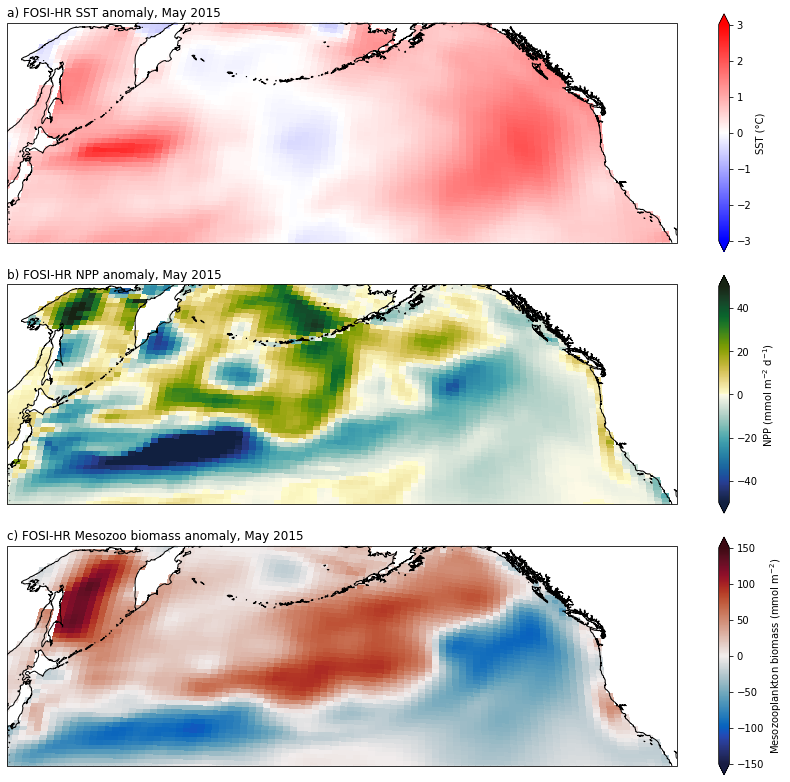

In [21]:
fig = plt.figure(figsize=(15,14))


############### 
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('a) FOSI-HR SST anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.TEMP)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-3,vmax=3)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='SST (°C)')
                     
############### 
ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('b) FOSI-HR NPP anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.photoC_TOT_zint*0.01*86400.)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.delta,
                   vmin=-50,vmax=50)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='NPP (mmol m$^{-2}$ d$^{-1}$)')

############### 
ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=-170))
ax.set_extent([-220, -115, 30, 60], ccrs.PlateCarree())

ax.set_title('c) FOSI-HR Mesozoo biomass anomaly, May 2015', loc='left')

lon,lat,field = utils.adjust_pop_grid(lons, lats, ds_May2015_anom.mesozooC_zint_100m_2*0.01)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap=cmocean.cm.balance,
                   vmin=-150,vmax=150)
ax.coastlines('10m',linewidth=1)

cbar1 = fig.colorbar(pc,extend='both',label='Mesozooplankton biomass (mmol m$^{-2}$)')

fig.subplots_adjust(hspace=0.1)

fig.savefig('/glade/work/kristenk/figs/May2015_blob_x1.png', bbox_inches='tight', dpi=300, format='png');